In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
import os
import pc
import ecg_plot

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy import optimize
from scipy.io import loadmat
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import concatenate, GlobalAveragePooling1D
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Add, GRU
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPool1D, ZeroPadding1D, LSTM, Bidirectional

### Data Prep

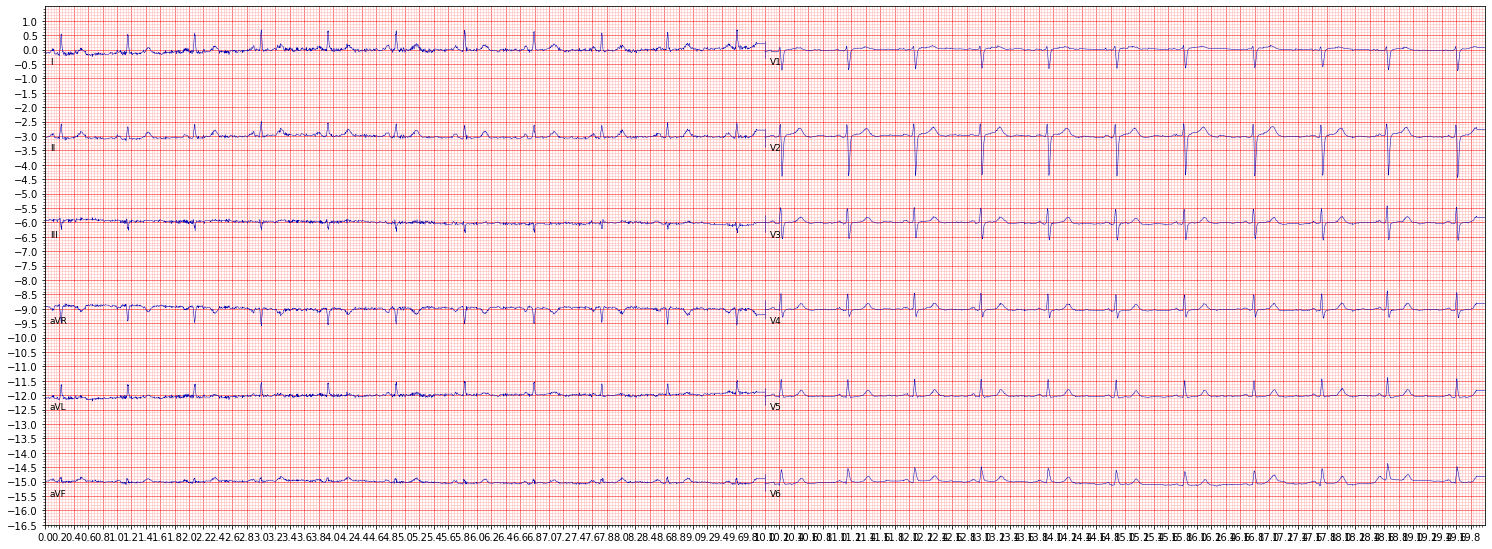

In [3]:
def plot_ecg(path):
    ecg_data = pc.load_challenge_data(path)
    ecg_plot.plot(ecg_data[0]/1000, sample_rate=500, title='')
    ecg_plot.show()
    
plot_ecg("WFDB/HR00001.mat")

In [4]:
gender, age, labels, ecg_filenames = pc.import_key_data("WFDB/")

In [5]:
ecg_filenames = np.asarray(ecg_filenames)

In [6]:
SNOMED_scored = pd.read_csv("SNOMED_mappings_scored.csv", sep=";")
SNOMED_unscored = pd.read_csv("SNOMED_mappings_unscored.csv", sep=";")
df_labels = pc.make_undefined_class(labels,SNOMED_unscored)

In [7]:
y , snomed_classes = pc.onehot_encode(df_labels)

The classes we will look at are encoded as SNOMED CT codes:
['10370003' '111975006' '164889003' '164890007' '164909002' '164917005'
 '164934002' '164947007' '251146004' '270492004' '284470004' '39732003'
 '426177001' '426783006' '427084000' '427393009' '445118002' '47665007'
 '59931005' '63593006' '698252002' '713426002' '713427006'
 'undefined class']
classes: 23


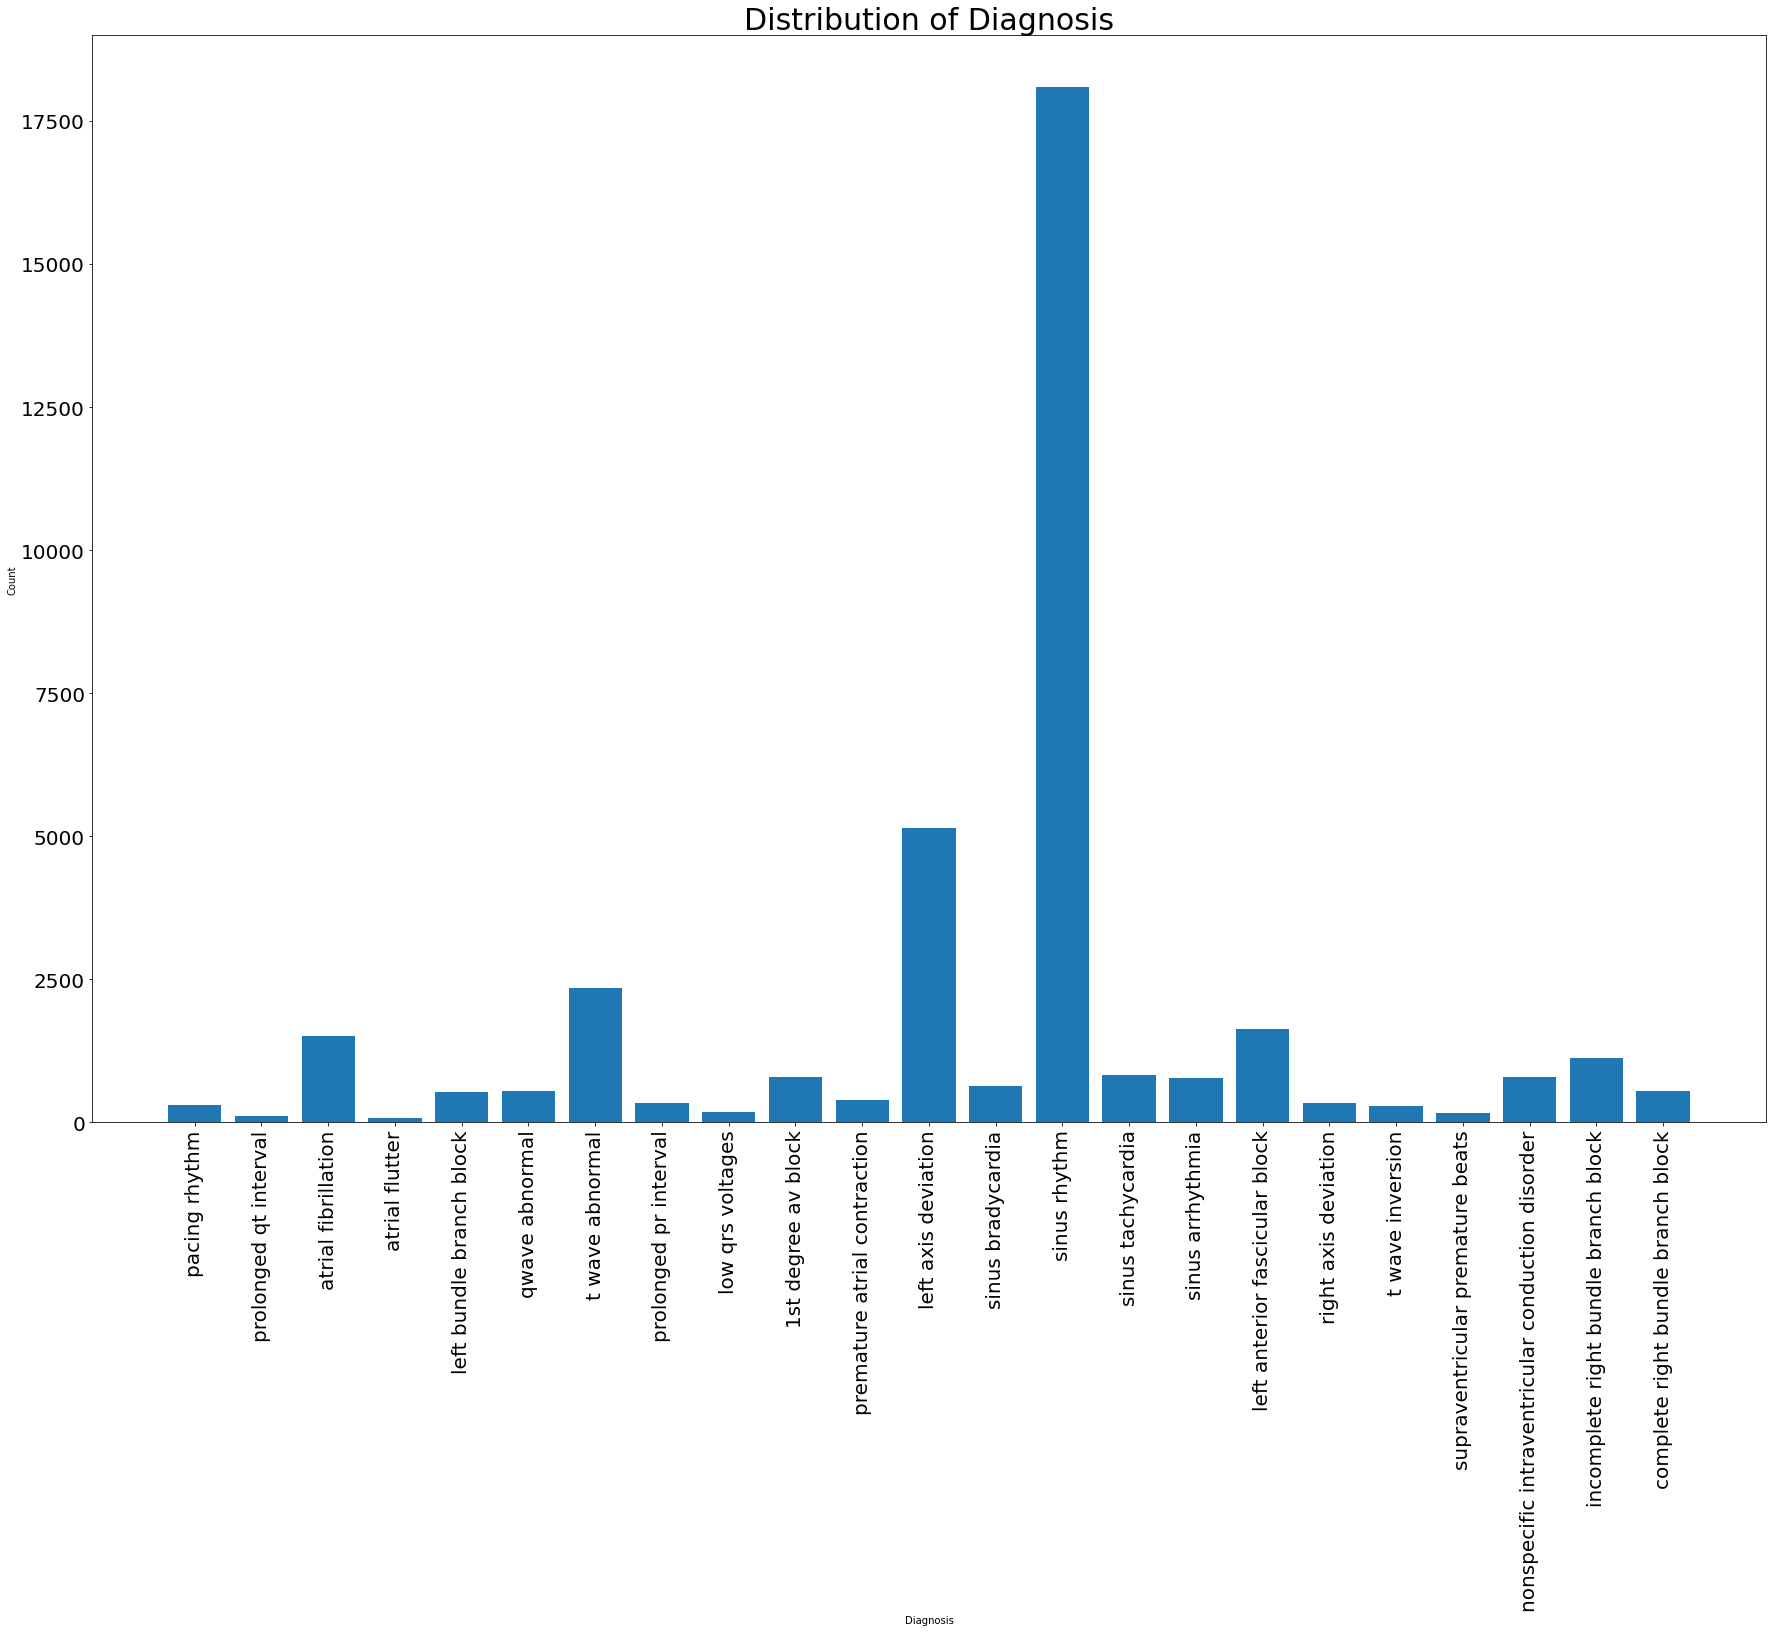

In [8]:
pc.plot_classes(snomed_classes, SNOMED_scored,y)

In [9]:
y_all_comb = pc.get_labels_for_all_combinations(y)
folds = pc.split_data(labels, y_all_comb)
order_array = folds[0][0]

Training split: 19653
Validation split: 2184


### Utility Functions

In [10]:
def shuffle_batch_generator(batch_size, gen_x,gen_y): 
    np.random.shuffle(order_array)
    batch_features = np.zeros((batch_size,5000, 12))
    batch_labels = np.zeros((batch_size,snomed_classes.shape[0])) 
    while True:
        for i in range(batch_size):

            batch_features[i] = next(gen_x)
            batch_labels[i] = next(gen_y)
            
        yield batch_features, batch_labels

def generate_y_shuffle(y_train):
    while True:
        for i in order_array:
            y_shuffled = y_train[i]
            yield y_shuffled


def generate_X_shuffle(X_train):
    while True:
        for i in order_array:
                #if filepath.endswith(".mat"):
                    data, header_data = pc.load_challenge_data(X_train[i])
                    X_train_new = pad_sequences(data, maxlen=5000, truncating='post',padding="post")
                    X_train_new = X_train_new.reshape(5000,12)
                    yield X_train_new

In [11]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_AUC', factor=0.1, patience=3, verbose=1, mode='max',
    min_delta=0.0001, cooldown=0, min_lr=0
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', mode='max', verbose=1, patience=3)

In [12]:
batchsize = 16

### Inception Model

In [13]:
def inception_block(prev_layer):
    
    conv1=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(prev_layer)
    conv1=BatchNormalization()(conv1)
    conv1=Activation('relu')(conv1)
    
    conv3=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(prev_layer)
    conv3=BatchNormalization()(conv3)
    conv3=Activation('relu')(conv3)
    conv3=Conv1D(filters = 64, kernel_size = 3, padding = 'same')(conv3)
    conv3=BatchNormalization()(conv3)
    conv3=Activation('relu')(conv3)
    
    conv5=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(prev_layer)
    conv5=BatchNormalization()(conv5)
    conv5=Activation('relu')(conv5)
    conv5=Conv1D(filters = 64, kernel_size = 5, padding = 'same')(conv5)
    conv5=BatchNormalization()(conv5)
    conv5=Activation('relu')(conv5)
    
    pool= MaxPool1D(pool_size=3, strides=1, padding='same')(prev_layer)
    convmax=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(pool)
    convmax=BatchNormalization()(convmax)
    convmax=Activation('relu')(convmax)
    
    layer_out = concatenate([conv1, conv3, conv5, convmax], axis=1)
    
    return layer_out

def inception_model(input_shape):
    X_input=Input(input_shape)
    
    X = ZeroPadding1D(3)(X_input)
    
    X = Conv1D(filters = 64, kernel_size = 7, padding = 'same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool1D(pool_size=3, strides=2, padding='same')(X)
    
    X = Conv1D(filters = 64, kernel_size = 1, padding = 'same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = inception_block(X)
    X = inception_block(X)
    
    X = MaxPool1D(pool_size=7, strides=2, padding='same')(X)
    
    X = GlobalAveragePooling1D()(X)
    X = Dense(23,activation='sigmoid')(X)
    
    model = Model(inputs = X_input, outputs = X, name='Inception')
    
    return model

In [14]:
inception_model = inception_model(input_shape = (5000,12))
inception_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [15]:
inception_model.summary()

Model: "Inception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5000, 12)]   0                                            
__________________________________________________________________________________________________
zero_padding1d (ZeroPadding1D)  (None, 5006, 12)     0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 5006, 64)     5440        zero_padding1d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 5006, 64)     256         conv1d[0][0]                     
__________________________________________________________________________________________

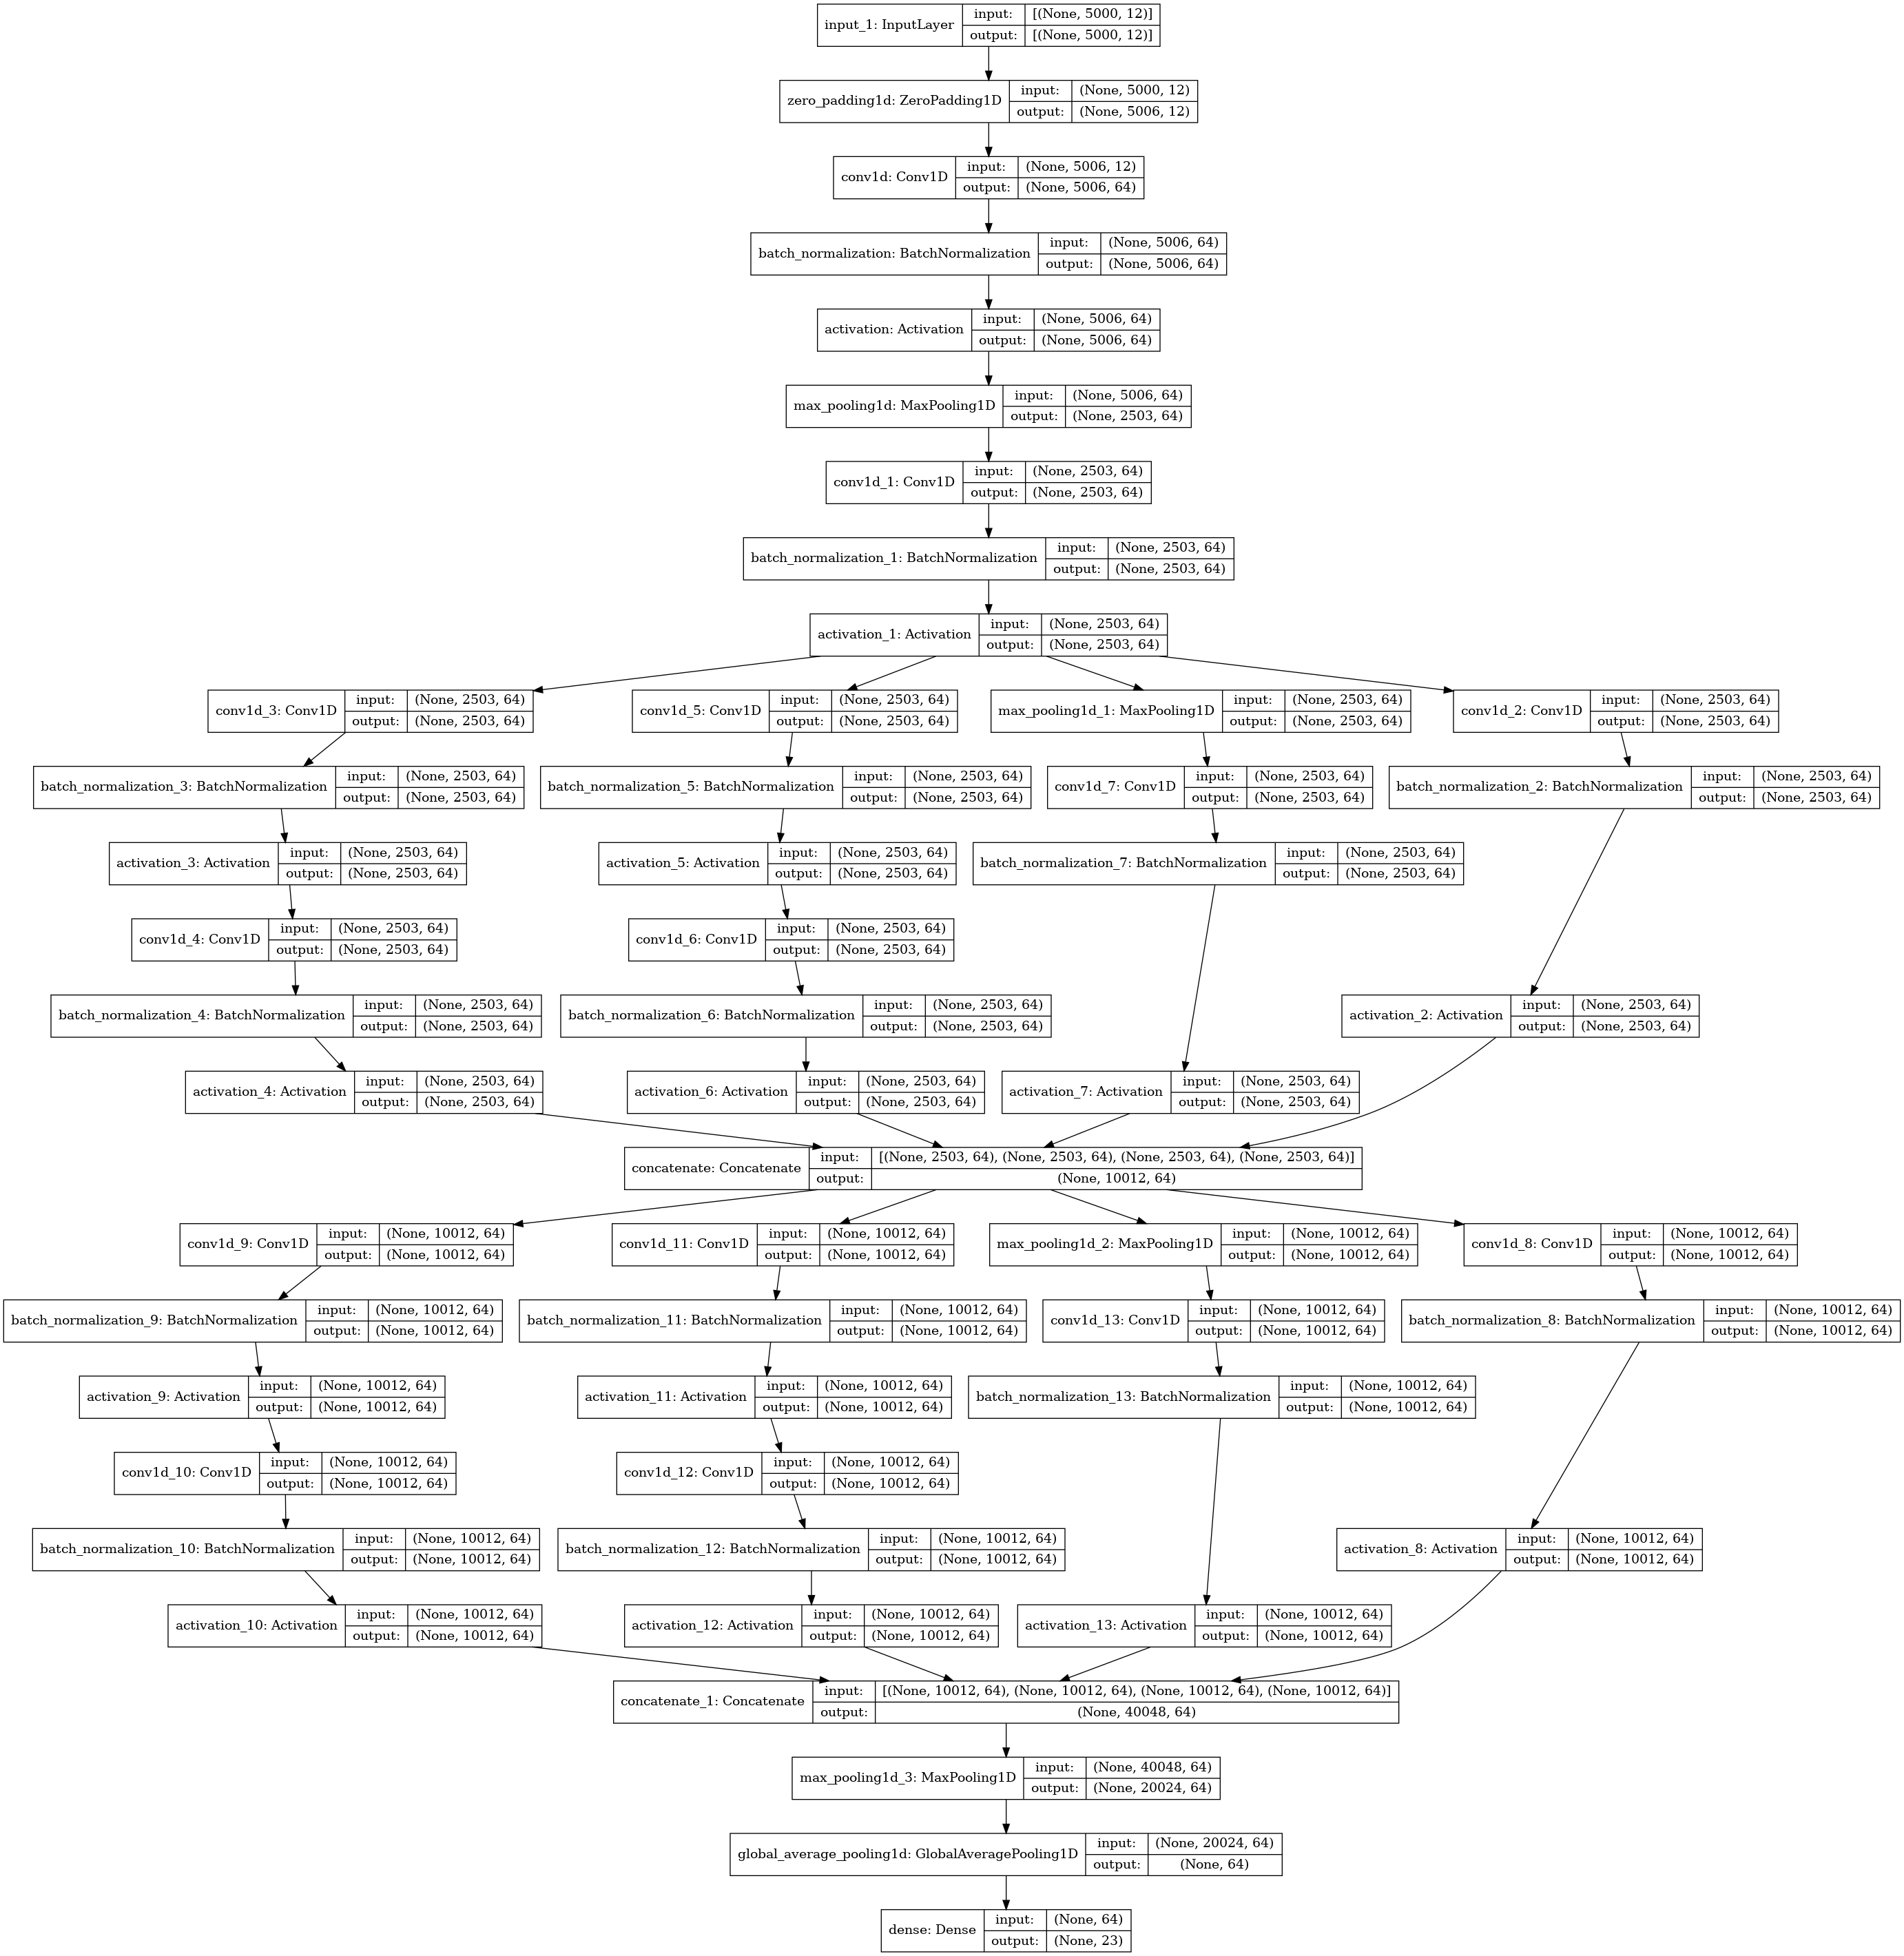

In [16]:
plot_model(inception_model, show_shapes=True)

In [17]:
inception_model.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames), \
                                            gen_y=generate_y_shuffle(y)), epochs=50, \
                  steps_per_epoch=(len(order_array)/(batchsize*10)), \
                  validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]), \
                  callbacks=[reduce_lr,early_stop])

Epoch 1/25
122/122 [==============================] - 12s 68ms/step - loss: 0.3233 - accuracy: 0.9010 - Recall: 0.4834 - Precision: 0.4295 - AUC: 0.4839 - val_loss: 0.2284 - val_accuracy: 0.9541 - val_Recall: 0.4785 - val_Precision: 0.8383 - val_AUC: 0.6760
Epoch 2/25
122/122 [==============================] - 7s 61ms/step - loss: 0.1463 - accuracy: 0.9535 - Recall: 0.4837 - Precision: 0.8142 - AUC: 0.6897 - val_loss: 0.1503 - val_accuracy: 0.9538 - val_Recall: 0.4830 - val_Precision: 0.8285 - val_AUC: 0.7691
Epoch 3/25
122/122 [==============================] - 7s 61ms/step - loss: 0.1405 - accuracy: 0.9544 - Recall: 0.5022 - Precision: 0.8271 - AUC: 0.7362 - val_loss: 0.1416 - val_accuracy: 0.9531 - val_Recall: 0.5971 - val_Precision: 0.7275 - val_AUC: 0.7837
Epoch 4/25
122/122 [==============================] - 7s 61ms/step - loss: 0.1359 - accuracy: 0.9562 - Recall: 0.5110 - Precision: 0.8477 - AUC: 0.7674 - val_loss: 0.1300 - val_accuracy: 0.9589 - val_Recall: 0.5303 - val_Precisi

Text(0, 0.5, 'Accuracy')

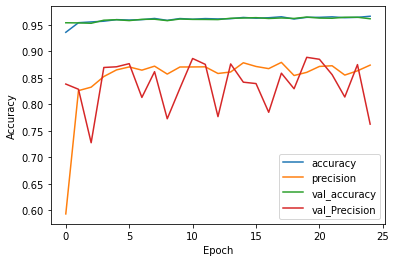

In [18]:
plt.plot(inception_model.history.history['accuracy'])
plt.plot(inception_model.history.history['Precision'])
plt.plot(inception_model.history.history['val_accuracy'])
plt.plot(inception_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

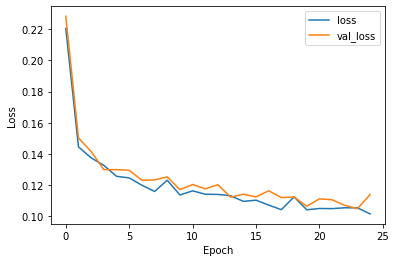

In [19]:
plt.plot(inception_model.history.history['loss'])
plt.plot(inception_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

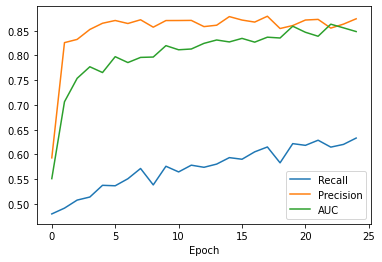

In [20]:
plt.plot(inception_model.history.history['Recall'])
plt.plot(inception_model.history.history['Precision'])
plt.plot(inception_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

In [21]:
inception_model.save('inception_model.h5')

### Conv1D-Stack

In [22]:
model_conv1d = Sequential()

model_conv1d.add(Conv1D(filters=6, kernel_size=3, padding='same', input_shape=(5000,12)))
model_conv1d.add(BatchNormalization())
model_conv1d.add(Activation('relu'))
model_conv1d.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

model_conv1d.add(Conv1D(filters=16, strides=1, kernel_size=5))
model_conv1d.add(BatchNormalization())
model_conv1d.add(Activation('relu'))
model_conv1d.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

model_conv1d.add(GlobalAveragePooling1D())

model_conv1d.add(Dense(64, activation='relu'))
model_conv1d.add(Dropout(0.25))
model_conv1d.add(Dense(32, activation='relu'))
model_conv1d.add(Dropout(0.25))
model_conv1d.add(Dense(23, activation='sigmoid'))

In [23]:
model_conv1d.compile(loss = tf.keras.losses.BinaryCrossentropy(), \
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), \
                     metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5), tf.keras.metrics.Recall(name='Recall'), \
                              tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [24]:
model_conv1d.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 5000, 6)           222       
_________________________________________________________________
batch_normalization_14 (Batc (None, 5000, 6)           24        
_________________________________________________________________
activation_14 (Activation)   (None, 5000, 6)           0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 2500, 6)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 2496, 16)          496       
_________________________________________________________________
batch_normalization_15 (Batc (None, 2496, 16)          64        
_________________________________________________________________
activation_15 (Activation)   (None, 2496, 16)          0

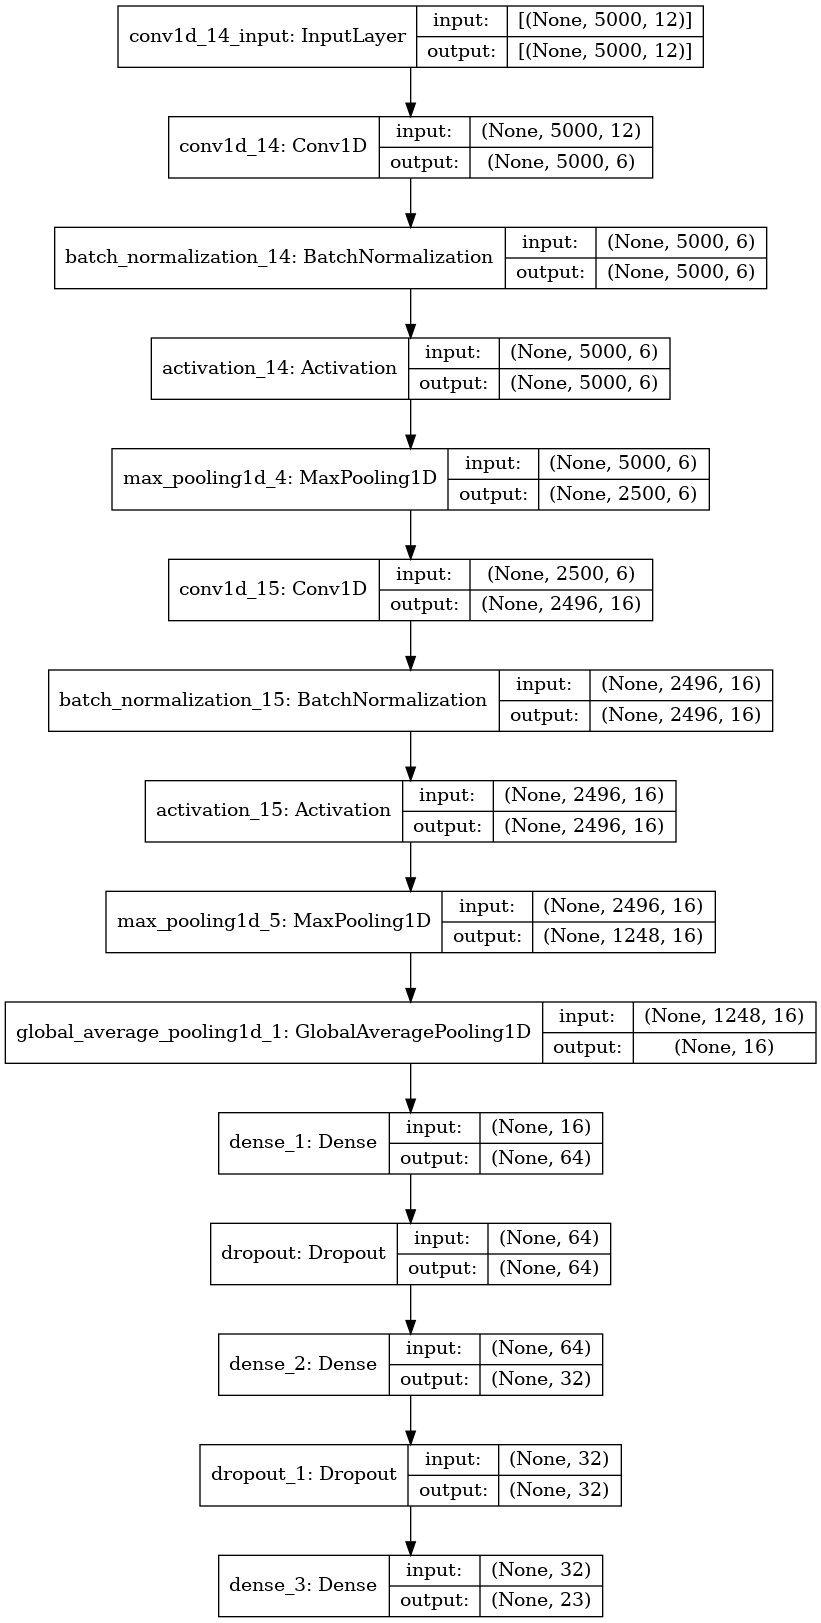

In [25]:
plot_model(model_conv1d, show_shapes=True)

In [26]:
model_conv1d.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames), \
                                            gen_y=generate_y_shuffle(y)), epochs=25, \
                  steps_per_epoch=(len(order_array)/(batchsize*10)), \
                  validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]), \
                  callbacks=[reduce_lr,early_stop])

Epoch 1/25
122/122 [==============================] - 3s 15ms/step - loss: 0.5136 - accuracy: 0.7650 - Recall: 0.3734 - Precision: 0.1495 - AUC: 0.4617 - val_loss: 0.2522 - val_accuracy: 0.9537 - val_Recall: 0.4814 - val_Precision: 0.8288 - val_AUC: 0.5465
Epoch 2/25
122/122 [==============================] - 1s 11ms/step - loss: 0.1844 - accuracy: 0.9513 - Recall: 0.4911 - Precision: 0.7784 - AUC: 0.5029 - val_loss: 0.1806 - val_accuracy: 0.9537 - val_Recall: 0.4814 - val_Precision: 0.8288 - val_AUC: 0.6536
Epoch 3/25
122/122 [==============================] - 1s 11ms/step - loss: 0.1716 - accuracy: 0.9529 - Recall: 0.4883 - Precision: 0.8064 - AUC: 0.5265 - val_loss: 0.1603 - val_accuracy: 0.9537 - val_Recall: 0.4814 - val_Precision: 0.8288 - val_AUC: 0.6540
Epoch 4/25
122/122 [==============================] - 1s 11ms/step - loss: 0.1771 - accuracy: 0.9518 - Recall: 0.4729 - Precision: 0.8003 - AUC: 0.5299 - val_loss: 0.1579 - val_accuracy: 0.9537 - val_Recall: 0.4814 - val_Precisio

Text(0, 0.5, 'Accuracy')

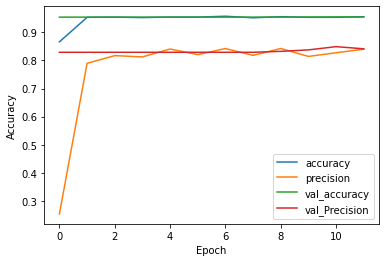

In [27]:
plt.plot(model_conv1d.history.history['accuracy'])
plt.plot(model_conv1d.history.history['Precision'])
plt.plot(model_conv1d.history.history['val_accuracy'])
plt.plot(model_conv1d.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

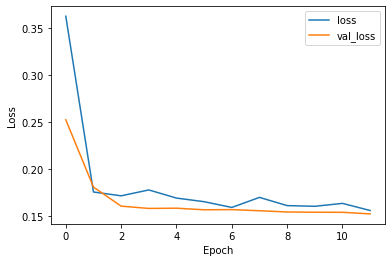

In [28]:
plt.plot(model_conv1d.history.history['loss'])
plt.plot(model_conv1d.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

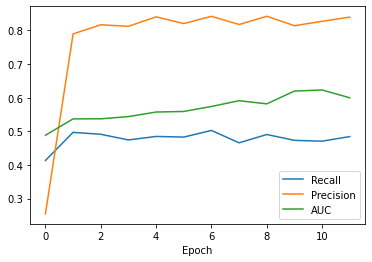

In [29]:
plt.plot(model_conv1d.history.history['Recall'])
plt.plot(model_conv1d.history.history['Precision'])
plt.plot(model_conv1d.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

In [30]:
model_conv1d.save('conv1dstack.h5')

### GRU Model

In [32]:
lstm_model = Sequential()
lstm_model.add(tf.keras.layers.InputLayer((5000,12)))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(LSTM(32, return_sequences = True))
lstm_model.add(GlobalAveragePooling1D())
lstm_model.add(Dense(128, activation = 'relu'))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(23, activation = 'sigmoid'))

In [33]:
lstm_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), \
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),\
                   metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),\
                            tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [34]:
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 5000, 64)          19712     
_________________________________________________________________
lstm_3 (LSTM)                (None, 5000, 32)          12416     
_________________________________________________________________
global_average_pooling1d_2 ( (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               4224      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 23)                2967      
Total params: 39,319
Trainable params: 39,319
Non-trainable params: 0
__________________________________________________

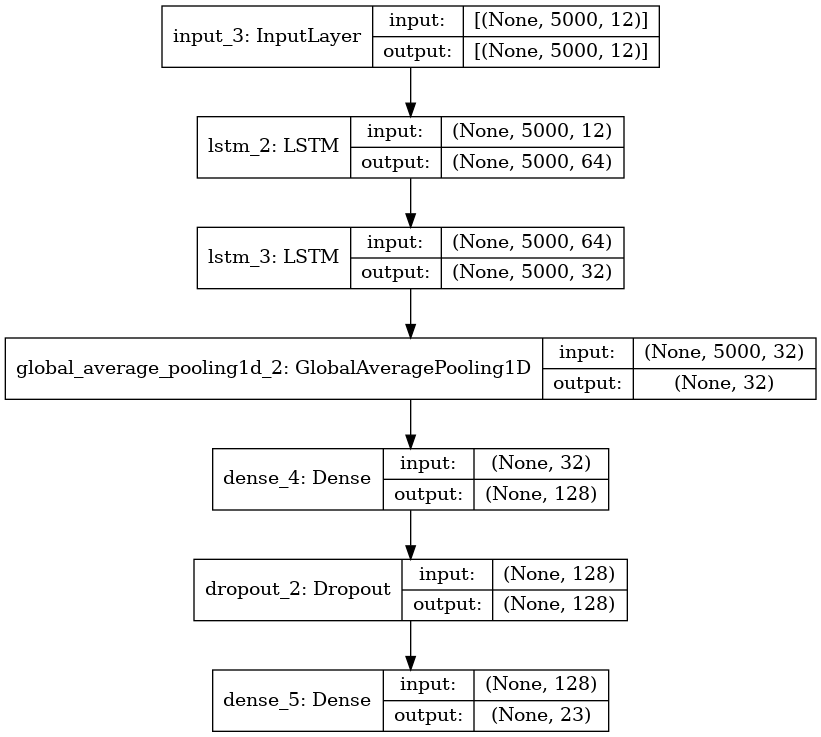

In [35]:
plot_model(lstm_model, show_shapes = True)

In [36]:
lstm_model.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames),\
                                         gen_y=generate_y_shuffle(y)), epochs=50, \
               steps_per_epoch=(len(order_array)/(batchsize*10)), \
               validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]))

Epoch 1/25
122/122 [==============================] - 33s 254ms/step - loss: 0.3868 - accuracy: 0.8640 - Recall: 0.5042 - Precision: 0.3484 - AUC: 0.4859 - val_loss: 0.1627 - val_accuracy: 0.9537 - val_Recall: 0.4814 - val_Precision: 0.8288 - val_AUC: 0.5486
Epoch 2/25
122/122 [==============================] - 31s 249ms/step - loss: 0.1681 - accuracy: 0.9542 - Recall: 0.4893 - Precision: 0.8122 - AUC: 0.4853 - val_loss: 0.1622 - val_accuracy: 0.9537 - val_Recall: 0.4814 - val_Precision: 0.8288 - val_AUC: 0.5575
Epoch 3/25
122/122 [==============================] - 31s 250ms/step - loss: 0.1727 - accuracy: 0.9518 - Recall: 0.4760 - Precision: 0.8099 - AUC: 0.4822 - val_loss: 0.1601 - val_accuracy: 0.9537 - val_Recall: 0.4814 - val_Precision: 0.8288 - val_AUC: 0.6294
Epoch 4/25
122/122 [==============================] - 31s 253ms/step - loss: 0.1703 - accuracy: 0.9512 - Recall: 0.4674 - Precision: 0.8187 - AUC: 0.5386 - val_loss: 0.1559 - val_accuracy: 0.9539 - val_Recall: 0.4870 - val_

Text(0, 0.5, 'Accuracy')

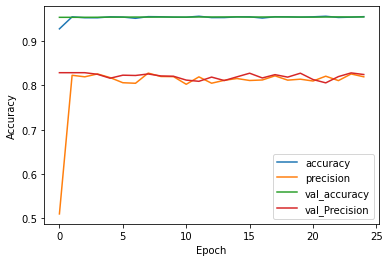

In [37]:
plt.plot(lstm_model.history.history['accuracy'])
plt.plot(lstm_model.history.history['Precision'])
plt.plot(lstm_model.history.history['val_accuracy'])
plt.plot(lstm_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

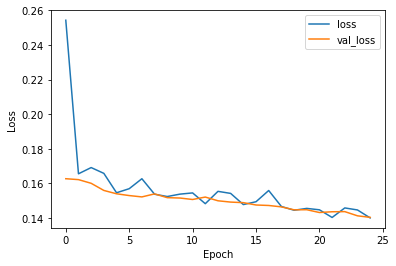

In [38]:
plt.plot(lstm_model.history.history['loss'])
plt.plot(lstm_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

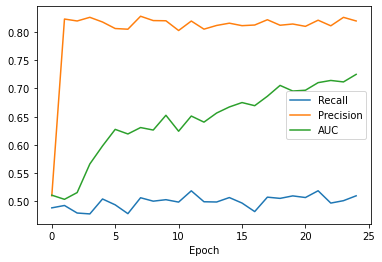

In [39]:
plt.plot(lstm_model.history.history['Recall'])
plt.plot(lstm_model.history.history['Precision'])
plt.plot(lstm_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

In [40]:
lstm_model.save('lstmmodel.h5')